# taxi-trip-duration

Use the "Run" button to execute the code.

In [167]:
!pip install jovian --upgrade --quiet

In [168]:
import jovian

In [169]:
# Execute this to save new versions of the notebook
jovian.commit(project="taxi-trip-duration")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/kathirvelramakrishnan/taxi-trip-duration


'https://jovian.ai/kathirvelramakrishnan/taxi-trip-duration'

# **Dataset:   New York City Taxi Trip Duration**


# **Problem Statement :**


 The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

## **File descriptions**
* train.csv - the training set (contains 1458644 trip records)
* test.csv - the testing set (contains 625134 trip records)
* sample_submission.csv - a sample submission file in the correct format

#  Modelling Objective : Building a model to improve the Ride Time Predictions

# Importing Necessary Libraries and install the required modules

In [170]:
! pip install folium



In [171]:
!pip install opendatasets

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
import opendatasets as od
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer as Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
import zipfile

# Use opendatasets module to download the datasets

In [173]:
od.download('https://www.kaggle.com/c/nyc-taxi-trip-duration/data',force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kathirvelr
Your Kaggle Key: ··········


100%|██████████| 85.8M/85.8M [00:00<00:00, 204MB/s]



Extracting archive ./nyc-taxi-trip-duration/nyc-taxi-trip-duration.zip to ./nyc-taxi-trip-duration


In [174]:
os.listdir('nyc-taxi-trip-duration')

['train.zip', 'test.zip', 'sample_submission.zip']

In [175]:
train = pd.read_csv("./nyc-taxi-trip-duration/train.zip")


In [176]:
test=pd.read_csv("./nyc-taxi-trip-duration/test.zip")

# Convert to appropriate datatype
## convert pickup datetime and dropoff datetime into date-time object

In [177]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')
train.head()

id  vendor_id  ... store_and_fwd_flag trip_duration
0  id2875421  2          ...  N                  455         
1  id2377394  1          ...  N                  663         
2  id3858529  2          ...  N                  2124        
3  id3504673  2          ...  N                  429         
4  id2181028  2          ...  N                  435         

[5 rows x 11 columns]

# Check for Null(Missing) values in Datasets

In [178]:
train[pd.isnull(train)].sum()

id                    0.0
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

# Find the maximum and minimum pickup time to get the total timeperiod of datasets 

In [179]:
print("Min pickup time:",min(train['pickup_datetime']))
print("Max pickup time:",max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


# Create new day,month, hour info from Pickup time

In [180]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x : x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x : x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x : calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x : x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x : x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x : calendar.day_name[x.weekday()])

# Round latitude  longitude  to 3 decimal places

In [181]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x : round(x, 3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x : round(x, 3))

train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x : round(x, 3))
train['dropoff_longitude_round3'] = train['pickup_longitude'].apply(lambda x : round(x, 3))


# Based on Latitude and Longitude get the distance of the trip in km

In [182]:
def calculateDistance(row):
    R = 6373.0 # approximate radius of earth in km
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    
    a = sin(dlat / 2)** 2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance


In [183]:
train['trip_distance'] = train.apply(lambda row : calculateDistance(row), axis =1)
train.head()

id  vendor_id  ... dropoff_longitude_round3 trip_distance
0  id2875421  2          ... -73.982                   1.498991    
1  id2377394  1          ... -73.980                   1.806074    
2  id3858529  2          ... -73.979                   6.387103    
3  id3504673  2          ... -74.010                   1.485965    
4  id2181028  2          ... -73.973                   1.188962    

[5 rows x 24 columns]

In [184]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x : x/3600)
train.head()

id  vendor_id  ... trip_distance trip_duration_in_hour
0  id2875421  2          ...  1.498991      0.126389            
1  id2377394  1          ...  1.806074      0.184167            
2  id3858529  2          ...  6.387103      0.590000            
3  id3504673  2          ...  1.485965      0.119167            
4  id2181028  2          ...  1.188962      0.120833            

[5 rows x 25 columns]

# Exploratory Analysis

In [185]:
plt.figure(figsize = (10, 5))
sns.distplot(train['trip_duration_in_hour']).set_title('distribution of trip duration')
plt.xlabel('trip duration (in hour)')

Text(0.5, 0, 'trip duration (in hour)')

In [186]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

id  vendor_id  ... trip_distance trip_duration_in_hour
355003  id1864733  1          ...  20.154989     538.815556          
680594  id0369307  1          ...  5.984365      569.327222          
924150  id1325766  1          ...  1.635641      618.781111          
978383  id0053347  1          ...  19.906909     979.522778          

[4 rows x 25 columns]

There are 4 records which have very high trip duration, but the distance travelled is very low. These are outliers. It is not make Sense .Trip duration is also skewed, so let us take log transformation


Text(0.5, 1.0, 'distribution of trip duration (sec) in log scale')

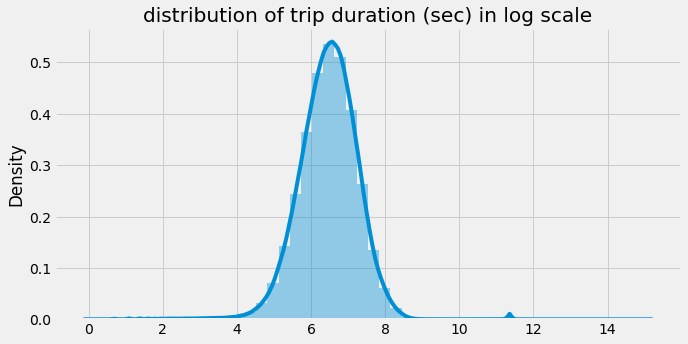

In [187]:
plt.figure(figsize = (10,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title('distribution of trip duration')
plt.title('distribution of trip duration (sec) in log scale')

**Log transformation of the trip duration results in a normal distribution.** Most trips are between 54 sec (exp(4)) and 2980 sec (exp(8)) . This indicates that most trip are withing one hour. But, there are trips which are less than a minute and need to be explored in detail.

Heatmap of common locations from where pickup and dropoff occurs

In [188]:
pickup = train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

## Convert the int64 dtype into float64 bcoz int64 is Not JSON serializable

In [189]:
pickup['Num_Trips'] = pickup['Num_Trips'].astype('float64')


In [190]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)

hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, 
                           pickup.pickup_longitude_round3.values,
                           pickup.Num_Trips.values)),
                  min_opacity = 0.2,
                  radius = 5, blur = 15,
                  max_zoom = 1)

pickup_map.add_child(hm_wide)

pickup_map

In [191]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(ncols = 1, sharex = True, sharey = True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           color = 'blue', label = 'train', alpha = 0.1)

fig.suptitle('lat lng of pickups in train data as scatter plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

## This graph clearly shows heavy density of pickups near JFK

In [192]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [193]:
for col in drop.columns:
    if drop[col].dtype != 'float64':
        drop[col] = drop[col].astype('float64')

In [194]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)

hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1)

drop_map.add_child(hm_wide)
drop_map

## Heatmap of trip duration, when pickup originates from a point

In [195]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration' : 'Avg_Trip_duration'})

In [196]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10)

hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values,
                           pickup.pickup_longitude_round3.values,
                           pickup.Avg_Trip_duration.values)),
                  min_opacity = 0.2,
                  radius = 7, blur = 15,
                  max_zoom = 1)

pickup_map.add_child(hm_wide)
pickup_map

In [197]:
plt.figure(figsize = (8, 5))
sns.countplot(x = train['pickup_hour']).set_title('pickup hours distribution')

Text(0.5, 1.0, 'pickup hours distribution')

In [198]:
plt.figure(figsize = (8, 5))
sns.countplot(x = train['dropoff_hour']).set_title('dropoff hours distribution')

Text(0.5, 1.0, 'dropoff hours distribution')

## Pickups over the entire time period

In [199]:
plt.figure(figsize = (8, 5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label = 'train')

plt.title('distribution of pickups over time')

Text(0.5, 1.0, 'distribution of pickups over time')

In [200]:
train['trip_distance'].values


array([1.4989912 , 1.80607396, 6.38710292, ..., 7.82706209, 1.09290687,
       1.13439796])

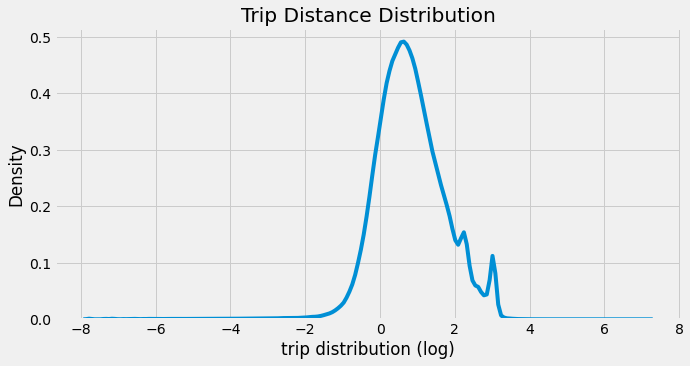

In [201]:
plt.figure(figsize = (10, 5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
#sns.kdeplot(np.log(train['trip_distance'].values)).set_title('trip distance distribution')
plt.xlabel('trip distribution (log)')
plt.show()


## Trip Duration vs Trip Distance

In [202]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
            color = 'blue', label = 'train')

plt.title('distribution of trip distance vs trip duration')
plt.xlabel('trip distribution (log scale)')
plt.ylabel('trip distribution (log scale)')

Text(0, 0.5, 'trip distribution (log scale)')

## Variation of Trip Duration at Different hours

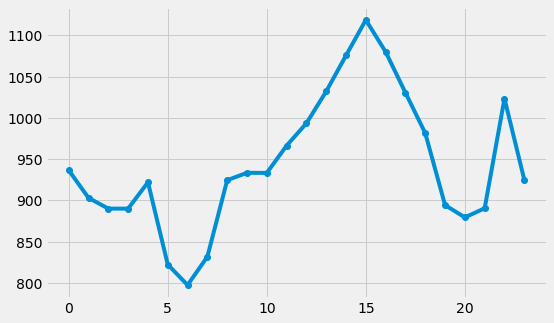

In [203]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration':'avg_trip_duration'})
plt.figure(figsize = (8, 5))
plt.plot(avg_duration_hour['avg_trip_duration'], 'o-')

## Plotting the Distribution of pickups across days

In [204]:
plt.figure(figsize = (10, 5))
sns.countplot(train['pickup_day_of_week'], order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])

## Analyze the Avg Trip Duration over Days of week using bargraph 

Text(0.5, 1.0, 'avg trip duration vs pickup days of week')

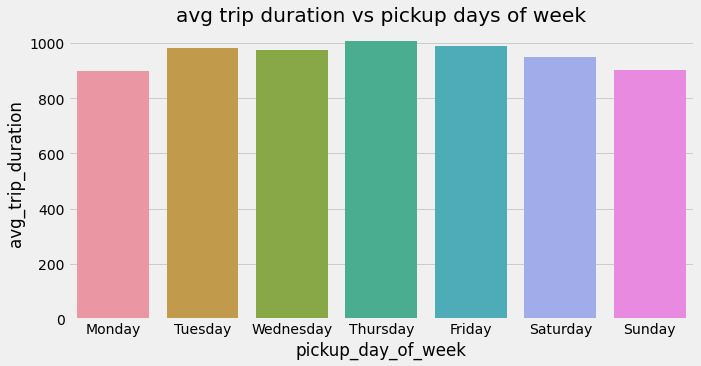

In [205]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration' : 'avg_trip_duration'})

plt.figure(figsize = (10, 5))
sns.barplot(x = 'pickup_day_of_week', y = 'avg_trip_duration', data = avg_duration_day,
            order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title('avg trip duration vs pickup days of week')

# Create a caluclated field Bearing 
## Bearing measures the direction of travel 
### The formula is: θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ ) λ is the longitude


In [206]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [207]:
train['bearing']=train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],
                                                         row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)

## Distribution of Bearing

In [208]:
train['pickup_latitude_round3']

0          40.768
1          40.739
2          40.764
3          40.720
4          40.793
            ...  
1458639    40.746
1458640    40.747
1458641    40.769
1458642    40.749
1458643    40.782
Name: pickup_latitude_round3, Length: 1458644, dtype: float64

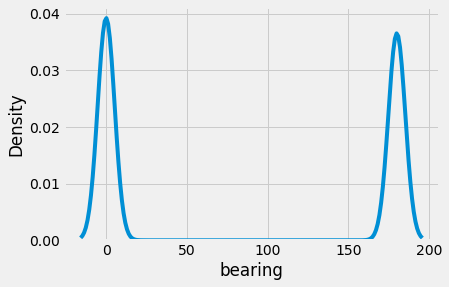

In [209]:
sns.kdeplot(train['bearing'])

## Bearing vs trip duration

Text(0, 0.5, 'trip duration (log scale)')

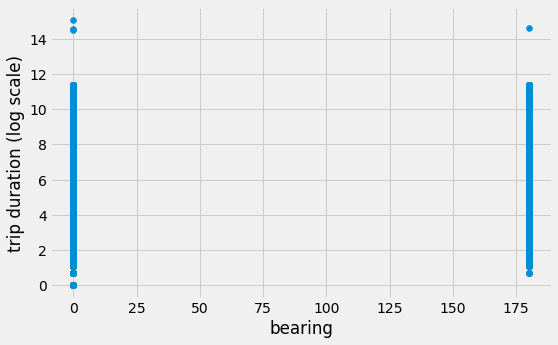

In [210]:
plt.figure(figsize = (8, 5))
plt.scatter(train['bearing'].values, y = np.log(train['trip_duration'].values))
plt.xlabel('bearing')
plt.ylabel('trip duration (log scale)')

In [211]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

Text(0, 0.5, 'Density')

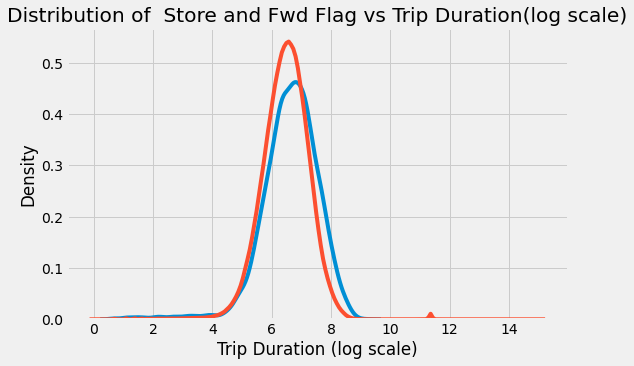

In [212]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y','trip_duration'].values),label= 'Store and Fwd =Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N','trip_duration'].values),label= 'Store and Fwd =No')
   
plt.title("Distribution of  Store and Fwd Flag vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')

Group Locations into cluster
This will help creating neighbourhoods. 
And pickups from certain neightbourhoods may have a longer trip duration

## So far we have learnt Kmeans clustering in unsupervised learning So I have used the *k-means algorithm* to group the locations(For Optimize the data) for creating neighbourhoods

Reference:
* https://jovian.ai/atomilee/k-means-clustering-creating-clusters"
* https://www.youtube.com/watch?v=1XqG0kaJVHY"


(-74.03, -73.75)

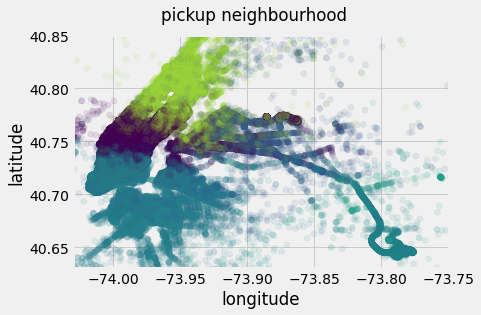

In [213]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                   train[['dropoff_latitude', 'dropoff_longitude']].values,
                   test[['pickup_latitude', 'pickup_longitude']].values,
                   test[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters = 8, random_state = 0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 
                                                            'dropoff_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude',
                                                            'pickup_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols = 1, sharex = True, sharey = True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           c = train['pickup_neighbourhood'], label = 'train', alpha = 0.1)
fig.suptitle('pickup neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)


**Number of pickups in each neighbourhood**

In [214]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhoods")

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhoods')

Text(0.5, 1.0, 'avg trip duration vs neighbourhood')

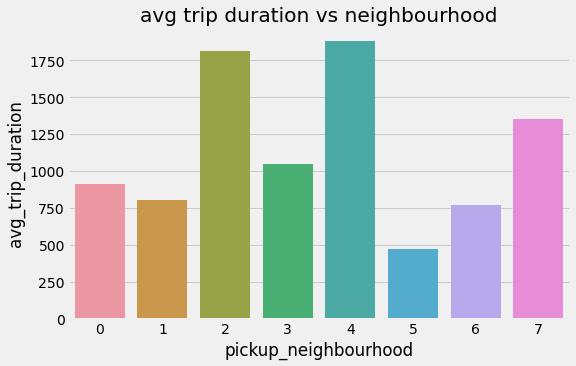

In [215]:
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration':'avg_trip_duration'})
plt.figure(figsize = (8, 5))
sns.barplot(x = 'pickup_neighbourhood', y ='avg_trip_duration',
            data = avg_duration_neighbourhood).set_title('avg trip duration vs neighbourhood')

Text(0.5, 1.0, 'Distribution of Average Speed (in kph)')

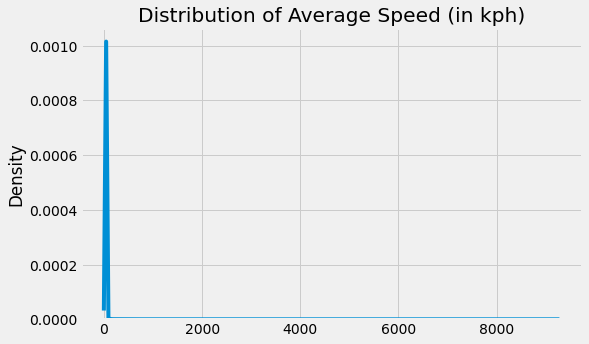

In [216]:
train['avg_speed_kph']=train['trip_distance']/train['trip_duration_in_hour']
plt.figure(figsize=(8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")

In [217]:
print("Average speed is",np.mean(train['avg_speed_kph']),"kph") #The average speed is 14 kmph

Average speed is 14.427736738458588 kph


## Average Speed across days of week - this is indication of traffic speed

In [218]:
avg_speed_per_day=train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_speed_kph',data=avg_speed_per_day,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")

Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

## Perform Feature Engineering on Test Data
**Identifying the categorical columns and encode them and impute the missling values**

In [219]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:calculateDistance(row),axis=1)
test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

Building Models
From the training data we need to drop "dropoff datetime features". We also only keep lat lng rounded to 3 decimal places

In [220]:
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training=train.drop(drop_cols,axis=1) 
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)

To avoid **Overfitting**,I have use less no of data for testing when compare to training 

In [221]:
training['log_trip_duration'] = training['trip_duration'].apply(lambda x:np.log(x))
training.drop(['trip_duration'], axis = 1, inplace = True)

In [222]:
print("Training Data Shape ",training.shape)
print("Testing Data Shape ",testing.shape)

Training Data Shape  (1458644, 18)
Testing Data Shape  (625134, 17)


In [223]:
def encodeDays(day_of_week):
    day_dict = {'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4,
                'Friday':5, 'Saturday':6}
    return day_dict[day_of_week]

In [224]:
training['pickup_day_of_week'] = training['pickup_day_of_week'].apply(lambda x:encodeDays(x))
testing['pickup_day_of_week'] = testing['pickup_day_of_week'].apply(lambda x:encodeDays(x))

# Copy the data from datasets and store it in csv file for giving the input to model 

In [225]:
training.to_csv('input_training.csv', index = False)
testing.to_csv('input_testing.csv', index = False)
del training
del testing
del train
del test


In [226]:
def LabelEncoding(train_df, test_df, max_levels = 2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col] = le.transform(train_df[col])
                test_df[col] = le.transform(test_df[col])
    return [train_df, test_df]


def readInputAndEncode(input_path,train_file,test_file,target_column):
    training = pd.read_csv(input_path + train_file)
    testing = pd.read_csv(input_path + test_file)
    
    training, testing = LabelEncoding(training, testing)
    train_cols = training.columns.tolist()
    test_cols = testing.columns.tolist()
    
    col_in_train_not_test = set(train_cols) - set(test_cols)
    for col in col_in_train_not_test:
        if col != target_column:
            testing[col] = 0
    
    col_in_test_not_train = set(test_cols) - set(train_cols)
    for col in col_in_test_not_train:
        training[col] = 0
    
    print('training data shape after preprocessing: ', training.shape)
    print('testing data shape after preprocessing: ', testing.shape)
    return [training, testing]


In [227]:
train,test=readInputAndEncode("",'input_training.csv','input_testing.csv','log_trip_duration')
train.drop(['pickup_date'],axis=1,inplace=True)
test.drop(['pickup_date'],axis=1,inplace=True)
train.drop(['pickup_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)
test_id=test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

training data shape after preprocessing:  (1458644, 18)
testing data shape after preprocessing:  (625134, 17)


# Here, We are Spliting the train and test data using GetFeaturesAndSplit function
## Inside the function i have used train_test_split method to split the data

In [228]:
def GetFeaturesAndSplit(train,test,target,imputing_strategy='median',
                        split=0.25,imputation=True):
    labels = np.array(train[target])
    training = train.drop(target, axis = 1)
    training = np.array(training)
    testing = np.array(test)
    
    if imputation == True:
        imputer = Imputer(strategy = imputing_strategy, missing_values = np.nan)
        imputer.fit(training)
        training = imputer.transform(training)
        testing = imputer.transform(testing)
        
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state = 42)
    return [train_features, validation_features, train_labels, validation_labels, testing]

In [229]:
train_features, validation_features, train_labels, validation_labels, testing = GetFeaturesAndSplit(train,test,'log_trip_duration',imputation=False)

# **In this project Im going to train the Two models:**
 
   ## * Linear Regression
   
   ## * Random Forest Regressor

  ## Note:  **Both of this models has been covered in Machine Learning with Python: Zero to GBMs course**
   
   
    

# For Validation we will use Grid Search cross validation strategy for Random Forest Regressor model


## Grid Search cross-validation is a technique to select the best of the machine learning model, parameterized by a grid of hyperparameters. Scikit-Learn library comes with grid search cross-validation implementation.

 ## Grid Search CV tries all combinations of parameters grid for a model and returns with the best set of parameters having the best performance score.

**For details and documentation refer:** 
- https://towardsdatascience.com/20x-times-faster-grid-search-cross-validation-19ef01409b7c
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# **Apply Linear Regression**

In [241]:
lm=linear_model.LinearRegression()
lm.fit(train_features,train_labels)
valid_pred=lm.predict(validation_features)
rmse=mean_squared_error(validation_labels,valid_pred)
print("Root Mean Squared Error for Linear Regression(log scale) ",rmse)

Root Mean Squared Error for Linear Regression(log scale)  0.3964946503447566


# Apply RandomForestRegressor 

In [242]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
rf.fit(train_features,train_labels)
valid_pred_rf=rf.predict(validation_features)
rmse=mean_squared_error(validation_labels,valid_pred_rf)
print("Root Mean Squared Error for Random Forest",rmse)
# Here our randomforestregressor model is performing very well when compare to Linear regression




Root Mean Squared Error for Random Forest 0.20112395243346168


# Making Sample Predictions

In [249]:
sample_valid_pred_rf=rf.predict(validation_features)
sample_valid_pred_lm=lm.predict(validation_features)

print("The first value of predicted sample using randomforestregressor : ",sample_valid_pred_rf[0])
print("The first value of predicted sample using Linear Regression : ",sample_valid_pred_lm[0])
print("The original value of targetvalue is :",validation_labels[0])
print("Our predicted values from models and original target values are mostly similar")
rmse_rf=mean_squared_error(sample_valid_pred_rf[1:10],validation_labels[1:10])
print("the rmse loss for predicted value for samples using randomforestregressor :",rmse_rf)
rmse_lm=mean_squared_error(sample_valid_pred_lm[1:10],validation_labels[1:10])
print("the rmse loss for predicted value for samples using Linear Regression :",rmse_lm)

The first value of predicted sample using randomforestregressor :  6.474202168369435
The first value of predicted sample using Linear Regression :  6.413430747333938
The original value of targetvalue is : 6.9469759921354175
Our predicted values from models and original target values are mostly similar
the rmse loss for predicted value for samples using randomforestregressor : 0.1506188365950823
the rmse loss for predicted value for samples using Linear Regression : 0.28087984897166707


# Here we are handling the large data and model give an output for each trip, so for storing the output(duration for each trip) I m using csv files 

## * For LinearRegression Model : submission_linear_regression_baseline.csv

## * For RandomForestRegressor Model:submission_random_forest_baseline.csv

In [ ]:
test_pred=lm.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_linear_regression_baseline.csv",index=False)
del submit

In [ ]:
test_pred=rf.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_random_forest_baseline.csv",index=False)

# Here the Rmse loss is very less for both models so our models are working well 

# Summary
**In this project we have:**
 - Downloaded a realworld data from kaggle
 - Carried out Exploratory Data Analysis 
 - Done feature engineering
 - Trained two models: Random Forest Regressor and Linear Regression
 - Used Grid Search cross validation as a validation strategy
 - Tuned two hyper parameters for each model namely: n_estimators and max_depth to avoid overfitting
 - Find the rmse loss for the both models ,rmse loss are very less,
 hence our models are working fine
 - Made sample predictions by selecting 10 data from predicted values of both the models with original target values from datasets
 - Find the rmse loss for sample predictions and our models predictions has less deviation from original values
 - Finally the  duration for each taxi trip is predicted  .

# Conclusion :
## On Analyzing the  rmse loss and various parameters ,both linear regression and randomforestregressor models are working fine and predicting the correct value and therefore ,this models are best suited for this problem.

# References:
* https://developers.google.com/maps/documentation/javascript/heatmaplayer
* https://www.youtube.com/watch?v=SrY0sTJchHE&list=PLfFghEzKVmjvuSA67LszN1dZ-Dd_pkus6&index=13
* https://towardsdatascience.com/linear-regression-models-4a3d14b8d368
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
* https://machinelearningmastery.com/random-forest-ensemble-in-python/
* https://jovian.ai/atomilee/k-means-clustering-creating-clusters



## My Suggestions for future work
- Using ML algorithms to predict asteroids movements to prevents from asteroid attacks.
- Using ML Models to predict the economic growth.
- Using Ml models to customized ads.

In [247]:
jovian.commit(project="taxi trip duration")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/kathirvelramakrishnan/taxi-trip-duration


'https://jovian.ai/kathirvelramakrishnan/taxi-trip-duration'

In [248]:
jovian.submit(assignment="zerotogbms-project")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/kathirvelramakrishnan/taxi-trip-duration
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/assignment/course-project-real-world-machine-learning-model
